In [1]:
import torch
from AttGan import AttGAN
from functions import *
from functions import CelebAMaskHQSimple
from Arguments import Args
from torch.utils.data import Dataset
import matplotlib.pyplot as plt
import torchvision.transforms.functional as TF
import pandas as pd
import numpy as np

# Cargamos args exactamente igual que en training
args = Args()
args.n_attrs = len(args.attrs)
args.betas = (args.beta1, args.beta2)

# Crear AttGAN
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

attgan = AttGAN(args)
attgan.G = attgan.G.to(device)
attgan.D = attgan.D.to(device)
state = torch.load("files/G_step_333999.pth", map_location=device)
attgan.G.load_state_dict(state)

attgan.G.eval()
attgan.D.eval()

Discriminators(
  (conv): Sequential(
    (0): Conv2dBlock(
      (layers): Sequential(
        (0): Conv2d(3, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
        (1): InstanceNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=False)
        (2): LeakyReLU(negative_slope=0.01)
      )
    )
    (1): Conv2dBlock(
      (layers): Sequential(
        (0): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
        (1): InstanceNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=False)
        (2): LeakyReLU(negative_slope=0.01)
      )
    )
    (2): Conv2dBlock(
      (layers): Sequential(
        (0): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
        (1): InstanceNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=False)
        (2): LeakyReLU(negative_slope=0.01)
      )
    )
    (3): Conv2dBlock(
      (layers): Sequential(
        (0): Conv2d(

In [2]:
valid_full = torch.load("files/valid_full.pt")


class CompactCelebAValid(Dataset):
    def __init__(self, valid_full):
        super().__init__()
        self.images = valid_full["images"]       # Tensor (N, 3, 128, 128)
        self.labels = valid_full["attrs"]        # Tensor (N, n_attrs)
        self.attr_names = valid_full["attr_names"]

    def __len__(self):
        return self.images.shape[0]

    def __getitem__(self, idx):
        img = self.images[idx]       # ya está normalizado
        att = self.labels[idx]
        return img, att


In [3]:
valid_dataset = CompactCelebAValid(valid_full)

In [4]:
def run_attgan_on_dataset(idx, att_wish, attgan, valid_dataset, args):
    """
    Corre AttGAN sobre una imagen directamente desde valid_dataset.
    No hace transformaciones extra.
    """

    # Obtenemos img y atributos reales desde dataset
    img_tensor, att_real = valid_dataset[idx]   # img: [3,128,128], att: [4]

    # Preparamos batch
    img_batch = img_tensor.unsqueeze(0).to(device)

    # Preparamos atributos destino
    att_wish = att_wish.to(device).float()
    att_wish_ = (att_wish * 2 - 1) * args.thres_int

    # Inferencia AttGAN
    attgan.eval()
    with torch.no_grad():
        out = attgan.G(img_batch, att_wish_)

    # Desnormalizar para mostrar
    inp_vis = (img_tensor * 0.5 + 0.5).clamp(0,1)
    out_vis = (out[0] * 0.5 + 0.5).clamp(0,1)

    inp_pil = TF.to_pil_image(inp_vis.cpu())
    out_pil = TF.to_pil_image(out_vis.cpu())


    # Mostramos
    plt.figure(figsize=(10,5))

    plt.subplot(1,2,1)
    plt.title(f"Input dataset idx={idx}")
    plt.imshow(inp_pil)
    plt.axis("off")

    plt.subplot(1,2,2)
    plt.title("Output AttGAN")
    plt.imshow(out_pil)
    plt.axis("off")

    plt.show()


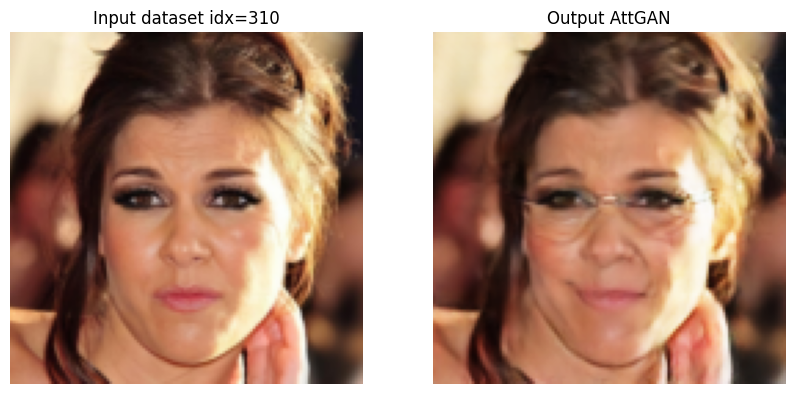

In [5]:
# (0, 499)
idx = 310
# Ejemplo: [Smiling, Bald, Heavy_Makeup, Eyeglasses]
att_wish = torch.tensor([[1,0,0,1]])  # ejemplo

run_attgan_on_dataset(idx, att_wish, attgan, valid_dataset, args)


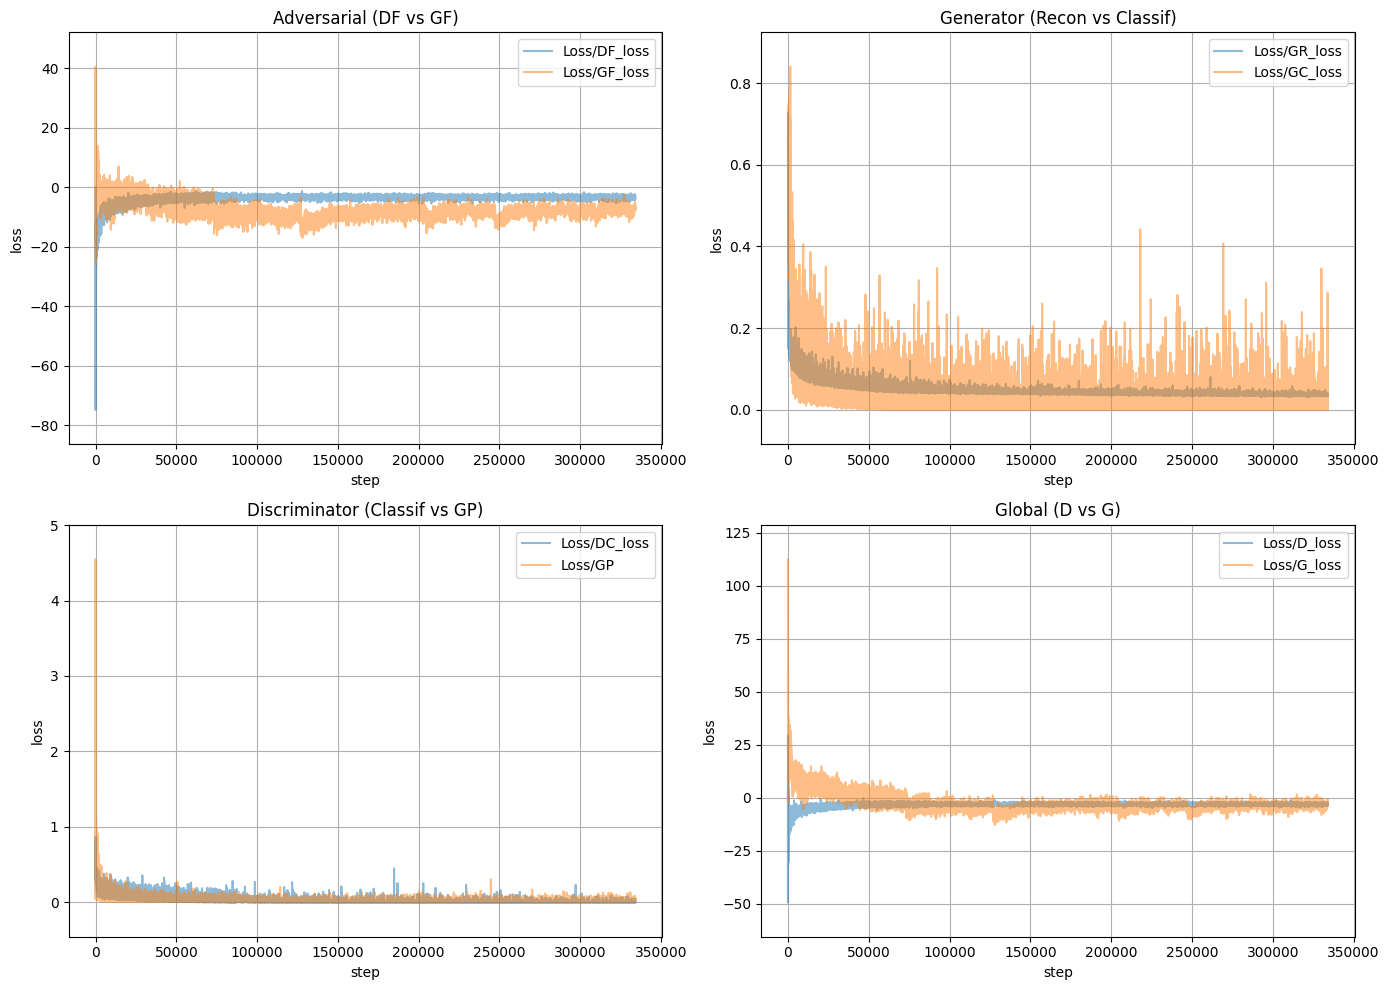

In [6]:
df = pd.read_csv("files/training_log_from_events.csv")
df = df.replace([np.inf, -np.inf], np.nan)

# Pares de pérdidas a graficar
pairs = [
    ("Loss/DF_loss", "Loss/GF_loss", "Adversarial (DF vs GF)"),
    ("Loss/GR_loss", "Loss/GC_loss", "Generator (Recon vs Classif)"),
    ("Loss/DC_loss", "Loss/GP",      "Discriminator (Classif vs GP)"),
    ("Loss/D_loss",  "Loss/G_loss",  "Global (D vs G)")
]

# Figura 2×2
fig, axs = plt.subplots(2, 2, figsize=(14,10))
axs = axs.flatten()

for ax, (c1, c2, title) in zip(axs, pairs):

    # Saltar si columnas no existen
    if c1 not in df or c2 not in df:
        ax.set_visible(False)
        continue

    # Extraer columnas
    step = df["step"].values
    y1 = df[c1].astype(float).values
    y2 = df[c2].astype(float).values

    # Máscaras válidas
    m1 = ~np.isnan(y1)
    m2 = ~np.isnan(y2)

    if m1.sum() == 0 or m2.sum() == 0:
        ax.set_visible(False)
        continue

    # Datos limpios
    step1, step2 = step[m1], step[m2]
    y1, y2 = y1[m1], y2[m2]

    # Límites automáticos
    ymin = min(y1.min(), y2.min())
    ymax = max(y1.max(), y2.max())
    if ymin == ymax:
        ymin -= 1
        ymax += 1
    else:
        margin = 0.1 * (ymax - ymin)
        ymin -= margin
        ymax += margin

    # Graficar
    ax.plot(step1, y1, label=c1, alpha=0.5)
    ax.plot(step2, y2, label=c2, alpha=0.5)
    ax.set_ylim(ymin, ymax)
    ax.set_title(title)
    ax.set_xlabel("step")
    ax.set_ylabel("loss")
    ax.grid(True)
    ax.legend()

plt.tight_layout()
plt.show()
